In [25]:
import os
import pickle
from dataclasses import dataclass, field
from typing import Annotated, Literal

from IPython.display import Markdown
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.constants import Send
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.types import Command
from pydantic import BaseModel, Field

### Environment and Global Configuration

In [12]:
if not os.environ.get("OPENAI_API_KEY"):
    raise ValueError("Please set OPENAI_API_KEY environment variable")

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0

EMBEDDING_MODEL = "text-embedding-3-small"
RETRIEVAL_K = 3

In [13]:
base_model = ChatOpenAI(model=LLM_MODEL, temperature=LLM_TEMPERATURE)

### Instanciate database and tool

In [7]:
def load_documents(pickle_filepath: str) -> list[Document]:
    """Load documents from a pickle file."""
    with open(pickle_filepath, "rb") as file:
        return pickle.load(file)


def initialize_vector_store(document_chunks: list[Document]) -> Chroma:
    """Reset the Chroma collection and initialize a vector store using document chunks."""
    Chroma().reset_collection()
    embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL)
    return Chroma.from_documents(documents=document_chunks, embedding=embedding_model)


data_dir = "../data/"
data_file = "bloomberg_financial_news.pkl"

documents = load_documents(os.path.join(data_dir, data_file))

vector_store = initialize_vector_store(documents[:1000])
retriever = vector_store.as_retriever(search_kwargs={"k": RETRIEVAL_K})

In [ ]:
from langchain_core.tools import tool


@tool
def retrieval(retrieval_query: str) -> list[Document]:
    """Retrieve documents based on a query."""
    return retriever.invoke(retrieval_query)

## LangGraph Workflow and state

![Orchestator Workflow](../imgs/8985fc683fae4780fb34eab1365ab78c7e51bc8e-2401x1000.webp)

State: shared state between all the nodes

messages: the message chain
analyses: the reserach analyses

Annotated: detail how to treat the data

In [ ]:
import operator


@dataclass(kw_only=True)
class WorkflowState:
    """Graph state tracking for the financial analysis workflow."""

    messages: Annotated[list, add_messages] = field(default_factory=list)
    analyses: Annotated[list, operator.add] = field(default_factory=list)

Constrained output: ask the model to output a particular format, leverages pydantic

In [14]:
class ResearchTask(BaseModel):
    """Task for the financial analysis workflow."""

    topic: str = Field(description="Topic of the research task.")
    description: str = Field(
        description="Brief description of the task and its objectives."
    )


class OrchestratorDecision(BaseModel):
    """List of research tasks for the financial analysis workflow."""

    response: str = Field(description="Rationale for the decision and research tasks.")
    in_scope: bool = Field(
        description="Wether the client request is in scope for the financial analysis."
    )
    research_tasks: list[ResearchTask] | None = Field(
        description="List of research tasks to be completed."
    )

### Orchestrator

In [15]:
# -----------------------------------------------------------------------------
# CIA Agent
# -----------------------------------------------------------------------------

CIA_PROMPT = """
You are a Client Interface Agent (CIA) in a financial analysis system. You have multiple Research Agents with access to Bloomberg Financial News under your supervision.

Given a client request, provide a concise, polite and professional response regarding the feasibility of the request and the approach that will be taken to address it.

If the user's request is addressable, create a short list of highly specific research topics that the Research Agents will investigate to fulfill the client's request.
"""

cia_model = base_model.with_structured_output(OrchestratorDecision)

In [16]:
def cia(state: WorkflowState) -> Command[Literal["research", END]]:
    """Orchestrator that generates a plan for the report."""
    orchestrator_output = cia_model.invoke(
        [
            SystemMessage(CIA_PROMPT),
            *state.messages,
        ]
    )
    print(orchestrator_output)

    return Command(
        update={"messages": orchestrator_output.response},
        goto=[Send("research", task) for task in orchestrator_output.research_tasks]
        if orchestrator_output.in_scope
        else END,
    )

### Research

In [17]:
BRA_PROMPT = """
You are a Research Agent in a financial analysis system. You are tasked with writing a concise research report on a specific topic provided by the Client Interface Agent (CIA) based on available documents.

To do so, you have access to a Bloomberg Financial News database that you can query. You should query the vector store for documents relevant to your task and write a concise summary of the information you find.

Your report should be short and informative, conveying only the most important information from the documents, to allow a Synthesis Agent to quickly generate a report for the client based on the findings of all Research Agents.

"""

tools = [retrieval]
tools_by_name = {tool.name: tool for tool in tools}
bra_model = base_model.bind_tools(tools)

In [18]:
def bra(task: ResearchTask) -> Command[Literal["synthesizer"]]:
    """Research agent that can query the vector store for relevant documents."""
    research = bra_model.invoke(
        [
            SystemMessage(BRA_PROMPT),
            HumanMessage(
                f"Research Task: {task.topic}\n\n Description: {task.description}"
            ),
        ]
    )

    if research.tool_calls:
        tool_call = research.tool_calls[0]
        tool = tools_by_name[tool_call["name"]]
        documents = tool.invoke(tool_call["args"])

        print([doc.metadata["Headline"] for doc in documents])

        research = base_model.invoke(
            [
                SystemMessage(BRA_PROMPT),
                HumanMessage(
                    f"Research Task: {task.topic}\n\n Description: {task.description}"
                ),
                research,
                ToolMessage(
                    content="\n\n".join(
                        [
                            f"{doc.metadata['Headline']}\n{doc.page_content}"
                            for doc in documents
                        ]
                    ),
                    tool_call_id=tool_call["id"],
                ),
            ]
        )

    print(research.content)

    return Command(
        update={"analyses": [research.content]},
        goto="synthesizer",
    )

### Synthetizer

In [19]:
MSSA_PROMPT = """
You are a Market Strategist & Synthesis Agent (MSSA) in a financial analysis system. You receive the analysis reports generated by the Research Agents, and are tasked with synthesizing the information into a final report for the client.

You should cross-reference the analyses and write a final report that covers the key findings in a clear and concise manner to address the client's request.
"""

In [20]:
def mssa(state: WorkflowState) -> Command[Literal[END]]:
    """Synthesize full report from research analyses."""
    analyses_reports = state.analyses

    complete_analyses = "\n\n---\n\n".join(analyses_reports)

    synthesizer_output = base_model.invoke(
        [
            SystemMessage(MSSA_PROMPT),
            *state.messages,
            HumanMessage(complete_analyses),
        ]
    )
    print(synthesizer_output.content)

    return Command(
        update={"messages": synthesizer_output},
        goto=END,
    )

### Graph building

In [21]:
# Build workflow
graph_builder = StateGraph(WorkflowState)

# Entry point
graph_builder.set_entry_point("orchestrator")

# Add the nodes
graph_builder.add_node("orchestrator", cia)
graph_builder.add_node("research", bra)
graph_builder.add_node("synthesizer", mssa)

# The edges are defined by the commands

# Compile the workflow
app = graph_builder.compile()

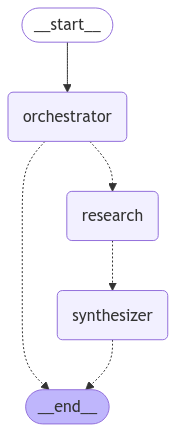

In [22]:
from IPython.display import Image

# Show the workflow
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
# Invoke
task = app.invoke(
    {
        "messages": "I want to invest in the technology sector. Can you please define an investment strategy?"
    }
)

response='Your request for an investment strategy in the technology sector is certainly in scope. We will focus on identifying key trends, potential growth areas, and risk factors within the sector to formulate a comprehensive strategy. Our Research Agents will investigate the following specific topics:' in_scope=True research_tasks=[ResearchTask(topic='Current Trends in Technology Investments', description='Analyze the latest trends in technology investments, including emerging technologies and sectors with high growth potential.'), ResearchTask(topic='Top Performing Technology Stocks', description='Identify and evaluate the top performing technology stocks over the past year and their future outlook.'), ResearchTask(topic='Risk Assessment in Technology Sector', description='Assess the risks associated with investing in the technology sector, including market volatility and regulatory challenges.'), ResearchTask(topic='Investment Strategies for Technology Sector', description='Explore

In [28]:
Markdown(task["messages"][-1].content)

### Final Investment Strategy Report: Technology Sector

#### Executive Summary
The technology sector presents a dynamic landscape for investment, characterized by rapid growth, emerging technologies, and significant market opportunities. This report synthesizes key findings from recent analyses, focusing on current trends, top-performing stocks, risk factors, and recommended investment strategies. 

#### Key Findings

1. **Current Trends**:
   - **Emerging Technologies**: AI, machine learning, and blockchain are at the forefront of investment interest, driving operational efficiencies and enhancing security in various sectors.
   - **Sector Growth**: The IT sector is rebounding, with companies like Wipro reporting increased demand. E-commerce is also on a growth trajectory, particularly in regions like Turkey, where the internet economy is expected to expand significantly.
   - **IPO Activity**: Japan's technology IPO market is booming, with a projected 67% increase in listings, indicating strong investor confidence and a favorable economic environment.

2. **Top Performing Stocks**:
   - **Wipro Ltd. (WPRO)**: Despite a modest stock increase of 8.6%, Wipro's future revenue projections are promising, although analysts remain cautious about its competitive position.
   - **Celestica Inc. (CLS)**: With a 31% stock surge, Celestica is well-positioned for continued growth, driven by strong demand in communications and diversification into defense.
   - **TT Electronics Plc (TTG)**: An 18% increase in stock value, supported by positive analyst upgrades, positions TT Electronics favorably for future growth.

3. **Risk Assessment**:
   - **Market Volatility**: The technology sector is prone to fluctuations influenced by economic conditions and investor sentiment. The recent IPO surge in Japan exemplifies this volatility, which can lead to overvaluation risks.
   - **Regulatory Challenges**: Increasing scrutiny from regulators, particularly in Europe and the U.S., poses risks to technology firms, especially those in financial services. Compliance with evolving regulations will be critical for maintaining profitability.

#### Recommended Investment Strategies

1. **Growth Investing**:
   - Focus on companies with high growth potential, particularly in software, social networking, and gaming. The current IPO landscape offers opportunities to invest in innovative firms poised for rapid expansion.

2. **Value Investing**:
   - Identify undervalued technology companies with strong fundamentals that may have been overlooked during market corrections. This strategy can yield significant returns as market conditions improve.

3. **Diversification Approaches**:
   - Mitigate risks by diversifying investments across various technology sub-sectors, such as cybersecurity, cloud computing, and AI. This approach not only reduces exposure to individual companies but also capitalizes on the overall growth of the tech industry.

#### Conclusion
Investing in the technology sector offers substantial opportunities, driven by emerging technologies and favorable market conditions. However, investors must remain vigilant regarding market volatility and regulatory challenges. A balanced investment strategy that incorporates growth and value investing, along with diversification, will be essential for navigating this evolving landscape. Staying informed about market trends and company fundamentals will further enhance the potential for successful investment outcomes in the technology sector.